5/5 [==============================] - 1s 67ms/step


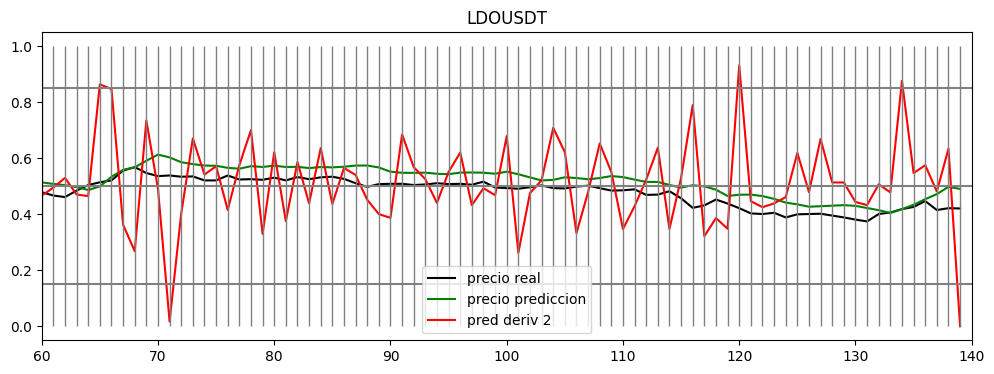

MSE: 0.0018889319916347192


In [8]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pandas_ta as ta
from binance import Client
import talib
from sklearn.preprocessing import MinMaxScaler
from keras.layers import LSTM
from keras.layers import Dense
from keras import optimizers
from keras.models import Model
from keras.layers import Dense, LSTM, Input, Activation
import numpy as np
from sklearn.metrics import mean_squared_error
import keras

symbol = 'LDOUSDT'
client = Client("qycthSI8s5HH0b95MxH3lFKPPUeZu8mCSgztp00x2d7SdHmfOp2U9qBeCCbxPyDg", 
                "zeJqYkyWzBIdGDMmyfUnofQiThirgEgOCDYvS3rzcq4yle1afD7YEQkciCI43yNs")

#######################################################################################
# Carga historial

timeframe='30m'
backcandles = 100 
historical_data = client.get_historical_klines(symbol, timeframe)
data = pd.DataFrame(historical_data)
data.columns = ['Open Time', 'Open', 'High', 'Low', 'Close', 'Volume', 'Close Time', 'Quote Asset Volume', 
                    'Number of Trades', 'TB Base Volume', 'TB Quote Volume', 'Ignore']
data['Open Time'] = pd.to_datetime(data['Open Time']/1000, unit='s')
data['Close Time'] = pd.to_datetime(data['Close Time']/1000, unit='s')
numeric_columns = ['Open', 'High', 'Low', 'Close', 'Volume', 'Quote Asset Volume', 'TB Base Volume', 'TB Quote Volume']
data[numeric_columns] = data[numeric_columns].apply(pd.to_numeric, axis=1)

#######################################################################################
# Indicadores

def get_bollinger_bands(df):
    mult = 2.0
    length = 20
    close = df['Close']
    basis = talib.SMA(close, length)
    dev = mult * talib.STDDEV(close, length)
    df['upper'] = basis + dev
    df['lower'] = basis - dev
    return df

def vwap(data):
    v = data['Volume'].values
    tp = (data['Low'] + data['Close'] + data['High']).div(3).values
    data['Vwap']=(tp * v).cumsum() / v.cumsum()
    return data

def checkhl(data_back, data_forward, hl):
    if hl == 'high' or hl == 'High':
        ref = data_back[len(data_back)-1]
        for i in range(len(data_back)-1):
            if ref < data_back[i]:
                return 0
        for i in range(len(data_forward)):
            if ref <= data_forward[i]:
                return 0
        return 1
    if hl == 'low' or hl == 'Low':
        ref = data_back[len(data_back)-1]
        for i in range(len(data_back)-1):
            if ref > data_back[i]:
                return 0
        for i in range(len(data_forward)):
            if ref >= data_forward[i]:
                return 0
        return 1
    
def pivot(data, LBL, LBR, highlow):
    df=data.copy()
    left = []
    right = []
    pivots=[]
    df['pivot']=0.0
    i=0
    last_value=0.0
    for index, row in df.iterrows():
        pivots.append(0.0)
        if i < LBL + 1:
            left.append(df.Close[i])
        if i > LBL:
            right.append(df.Close[i])
        if i > LBL + LBR:
            left.append(right[0])
            left.pop(0)
            right.pop(0)
            if checkhl(left, right, highlow):
                pivots[i - LBR] = df.Close[i - LBR]
                last_value = df.Close[i - LBR]
        df.at[index,'pivot'] = last_value
        i=i+1
    return df['pivot']

data['RSI']=ta.rsi(data.Close, length=15)
data['EMAF']=ta.ema(data.Close, length=20)
data['EMAM']=ta.ema(data.Close, length=50)
data['EMAS']=ta.ema(data.Close, length=200)
data['macd'], data['macd_signal'], data['macd_hist'] = talib.MACD(data['Close'], fastperiod=12, slowperiod=26, signalperiod=9)
data=get_bollinger_bands(data)
data['pivot_high'] = pivot(data, 24, 24, 'high')
data['pivot_low'] = pivot(data, 24, 24, 'low')
data['TARGET'] = data['Close'].shift(-1)

data.dropna(inplace=True)
data.reset_index(inplace = True)
data.drop(['Open Time','Close Time','Quote Asset Volume', 'TB Base Volume', 'TB Quote Volume','Number of Trades',
          'Ignore','index'], axis=1, inplace=True)
cantidad_campos_entrenar=len(data.columns)-1
data_set = data
pd.set_option('display.max_columns', None)
#######################################################################################
# formatea datos

sc = MinMaxScaler(feature_range=(0,1))
data_set_scaled = sc.fit_transform(data_set)
# multiple feature from data provided to the model
X = []
for j in range(cantidad_campos_entrenar):
    X.append([])
    for i in range(backcandles, data_set_scaled.shape[0]):#backcandles+2
        X[j].append(data_set_scaled[i-backcandles:i, j])
#move axis from 0 to position 2
X=np.moveaxis(X, [0], [2])
X, yi =np.array(X), np.array(data_set_scaled[backcandles:,-1])
y=np.reshape(yi,(len(yi),1))
# split data into train test sets
splitlimit = int(len(X)*0.8)
X_train, X_test = X[:splitlimit], X[splitlimit:]
y_train, y_test = y[:splitlimit], y[splitlimit:]

#######################################################################################
# Entrena o carga modelo

#np.random.seed(10)
#lstm_input = Input(shape=(backcandles, cantidad_campos_entrenar), name='lstm_input')
#lstm_layer1 = LSTM(150, return_sequences=True, name='lstm_layer1')(lstm_input)
#lstm_layer2 = LSTM(150, name='lstm_layer2')(lstm_layer1)
#dense_layer = Dense(1, name='dense_layer')(lstm_layer2)
#output_layer = Activation('linear', name='output')(dense_layer)
#model = Model(inputs=lstm_input, outputs=output_layer)
#adam = optimizers.Adam()
#model.compile(optimizer=adam, loss='mse')
#history=model.fit(x=X_train, y=y_train, batch_size=15, epochs=30, shuffle=True, validation_split=0.1)

model = keras.models.load_model('modelos/model'+symbol+'.h5')

# Grafica

y_pred = model.predict(X_test)
deriv_y_pred = np.diff(y_pred, axis=0)
deriv_y_pred2 = np.diff(deriv_y_pred, axis=0)
sc = MinMaxScaler(feature_range=(0,1))
deriv_y_pred_scaled = sc.fit_transform(deriv_y_pred)
deriv_y_pred_scaled2 = sc.fit_transform(deriv_y_pred2)

deriv_y_pred_scaled = np.insert(deriv_y_pred_scaled, 0, 0.0, axis=0)#para mover 1 posicion hacia adelante
deriv_y_pred_scaled2 = np.insert(deriv_y_pred_scaled2, 0, 0.0, axis=0)#para mover 1 posicion hacia adelante
deriv_y_pred_scaled2 = np.insert(deriv_y_pred_scaled2, 0, 0.0, axis=0)#para mover 1 posicion hacia adelante

plt.figure(figsize=(12,4))
plt.plot(y_test, color = 'black', label = 'precio real')
plt.plot(y_pred, color = 'green', label = 'precio prediccion')
#plt.plot(deriv_y_pred_scaled, color = 'blue', label = 'pred deriv 1')
plt.plot(deriv_y_pred_scaled2, color = 'red', label = 'pred deriv 2')

plt.xlim(60, 140)
umbralalto = 0.85
umbralmedio = 0.5
umbralbajo = 0.15

plt.axhline(y = umbralalto, color = 'GREY', linestyle = '-')
plt.axhline(y = umbralmedio, color = 'GREY', linestyle = '-')
plt.axhline(y = umbralbajo, color = 'GREY', linestyle = '-')
plt.legend()
plt.title(symbol)
for i in range(140):
    plt.vlines(x=i, ymin=0, ymax=1, color="GREY", linewidth=1)
plt.show()

# Calcular el MSE
mse = mean_squared_error(y_test, y_pred)
print('MSE:', mse)